Make a U-net that outputs bright features and everything else.

In [1]:
# Scans have a resolution of 512. Can divide these up so that we have windows of size 32*32.
# Use the patchify python library for this.


In [2]:
%pip install patchify

Binary UNet to find features and background. Again, we have some scans we use only for training, and some others we use for test/validation.

In [2]:
import numpy as np
import pandas as pd
import patchify as pat
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import random

# pytorch modules
import torch
from torch.utils.data import Dataset, Subset, DataLoader, RandomSampler
#from torchvision.transforms import ToTensor
import torch.nn as nn # nn class our model inherits from
import torch.optim as optim
from torchvision import transforms, datasets

from scipy.ndimage import gaussian_filter
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Si scans
#filled_k = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/undosed/numpy array/20200731-132153_Kenton-Si(001)-H--12_1_0.npy')[::2,::2]
#filled_AsEC1 = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/dosed/numpy arrays/20181123-122007_STM_AtomManipulation-Earls Court-Si(100)-H term--26_2_0.npy')[::2,::2]
#filled_AsH1 = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/dosed/numpy arrays/20200217-105833_Hainault-Si(001)-H-AsH3--30_2_0.npy')
#filled_AsH2 = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/dosed/numpy arrays/20200217-105833_Hainault-Si(001)-H-AsH3--27_1_0_topright.npy')
#filled_gr = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/undosed/numpy array/20181015-142255_STM_AtomManipulation-Gloucester Road-Si(100)-H--9_1_0.npy')[::2,::2]
#filled_n = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/image segmentation for mapping/20231027-095207_Neasden Si(001)-H--STM_AtomManipulation--9_2_0.npy')
#filled_b = np.load(r'/content/drive/My Drive/Colab Notebooks/AsH3 identification/image segmentation for mapping/20221213-141130_Brockley-Si(001)H-STM_AtomManipulation--23_2_0.npy')


# Si scans
filled_k = np.load(r'E:\nick\ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20200731-132153_Kenton-Si(001)-H--12_1_0.npy')[::2,::2]
filled_AsEC1 = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20181123-122007_STM_AtomManipulation-Earls Court-Si(100)-H term--26_2_0.npy')[::2,::2]
filled_AsH1 = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20200217-105833_Hainault-Si(001)-H-AsH3--30_2_0.npy')
filled_AsH2 = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20200217-105833_Hainault-Si(001)-H-AsH3--27_1_0_topright.npy')
filled_gr = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20181015-142255_STM_AtomManipulation-Gloucester Road-Si(100)-H--9_1_0.npy')[::2,::2]
filled_n = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20231027-095207_Neasden Si(001)-H--STM_AtomManipulation--9_2_0.npy')
filled_b = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20221213-141130_Brockley-Si(001)H-STM_AtomManipulation--23_2_0.npy')

In [8]:
# load the masks

# Si masks
maskgr = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20181015-142255_STM_AtomManipulation-Gloucester Road-Si(100)-H--9_1_mask_full.npy')[::-1,:]
maskAsEC1 = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20181123-122007_STM_AtomManipulation-Earls Court-Si(100)-H term--26_2_0_mask_full.npy')
maskk = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20200731-132153_Kenton-Si(001)-H--12_1_mask_full.npy')[::-1,:]
maskAsH1 = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20200217-105833_Hainault-Si(001)-H-AsH3--30_2_0_mask_full.npy')
maskAsH2 = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20200217-105833_Hainault-Si(001)-H-AsH3--27_1_0_topright_mask_full.npy')
maskn = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20231027-095207_Neasden Si(001)-H--STM_AtomManipulation--9_2_0_mask_full.npy')
maskb = np.load(r'E:/nick/ML_paper\Data\Segmentation_data\Si(001)-H-AsH3/20221213-141130_Brockley-Si(001)H-STM_AtomManipulation--23_2_0_mask_full.npy')



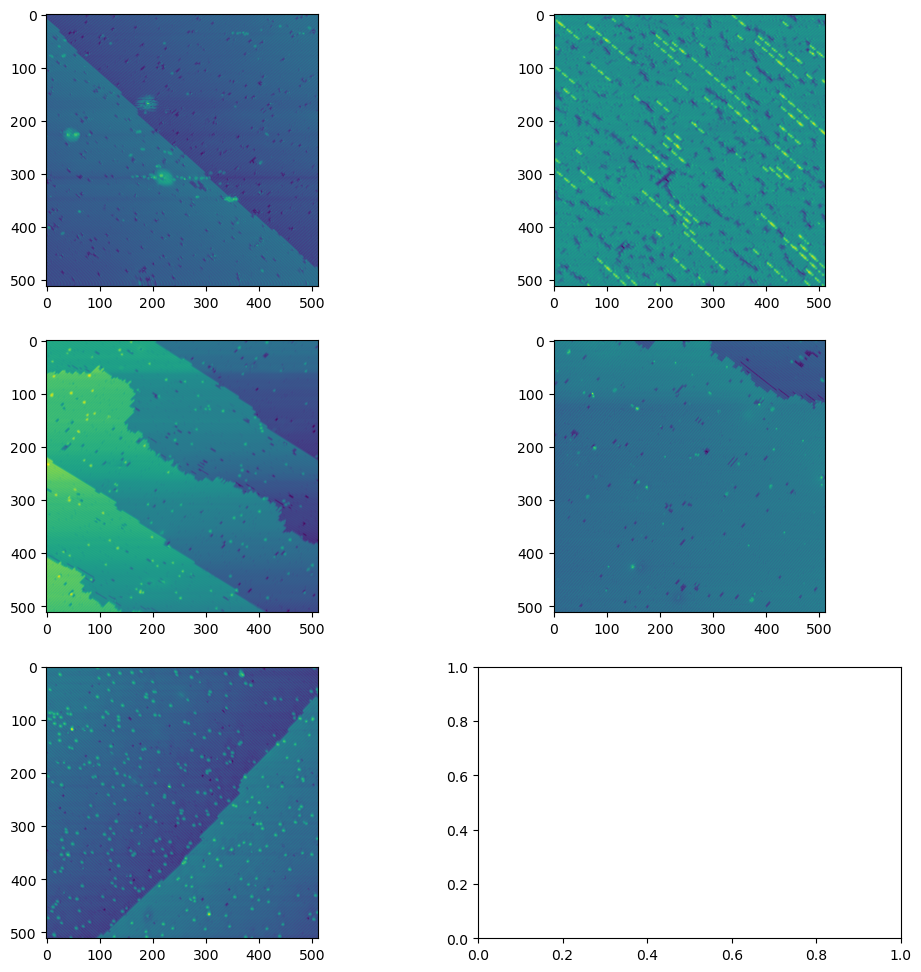

In [57]:
fig, axs = plt.subplots(3, 2, figsize = (12,12))
axs[0,0].imshow(filled_b)
axs[0,1].imshow(filled_n)
axs[1,0].imshow(filled_gr)
axs[1,1].imshow(filled_AsEC1)
axs[2,0].imshow(filled_k)


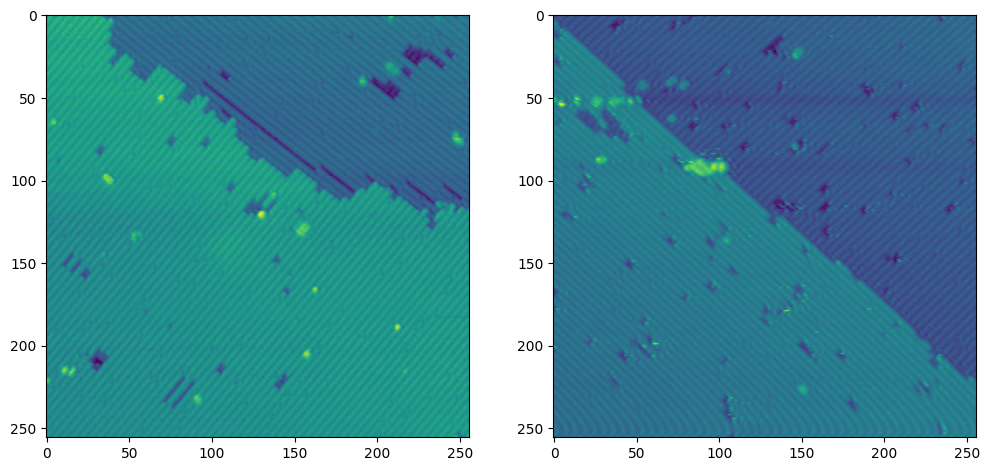

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (12,12))
axs[0].imshow(filled_AsEC1[:256,256:])
axs[1].imshow(filled_b[256:,256:])

In [9]:
# combine and turn to torch tensor

# Si
k = torch.tensor(np.stack((filled_k, maskk), axis=2).T).float()
gr = torch.tensor(np.stack((filled_gr, maskgr), axis=2).T).float()
AsEC1 = torch.tensor(np.stack((filled_AsEC1, maskAsEC1), axis=2).T).float()
AsH1 =  torch.tensor(np.stack((filled_AsH1, maskAsH1), axis=2).T).float()
AsH2 =  torch.tensor(np.stack((filled_AsH2, maskAsH2), axis=2).T).float()
n =  torch.tensor(np.stack((filled_n, maskn), axis=2).T).float()
b =  torch.tensor(np.stack((filled_b, maskb), axis=2).T).float()


In [45]:
print(k.shape, gr.shape, AsEC1.shape, AsH1.shape, AsH2.shape, n.shape, b.shape)

torch.Size([2, 512, 512]) torch.Size([2, 512, 512]) torch.Size([2, 512, 512]) torch.Size([2, 512, 512]) torch.Size([2, 512, 512]) torch.Size([2, 512, 512]) torch.Size([2, 512, 512])


In [10]:
x_test = {0:gr[:,256:,256:], 1:AsEC1[:,:256,256:], 2:k[:,256:,256:]}
x_val = {0:AsEC1[:,256:,256:], 1:b[:,256:,256:]}

#x_test = {0:gr, 1:k, 2:n,3:AsEC1} #, 4:AsH1, 5:AsH1}
#x_val = {0:b}

Now we need to normalise the data points. There's a number of ways we could do this. Let's try max/min (using the max/min of each crop separately) first

In [34]:
def normalise(array, per_row=True, error=False):
    if per_row:
        min_filled = np.expand_dims(np.amin(array[:,:,:,0], axis=(1,2)), axis=(1,2))
        max_filled = np.expand_dims(np.amax(array[:,:,:,0], axis=(1,2)), axis=(1,2))

        array[:,:,:,0] = (array[:,:,:,0]-min_filled)/(max_filled-min_filled)
        if error:
          min_error = np.expand_dims(np.amin(array[:,:,:,1], axis=(1,2)), axis=(1,2))
          max_error = np.expand_dims(np.amax(array[:,:,:,1], axis=(1,2)), axis=(1,2))
          array[:,:,:,1] = (array[:,:,:,1]-min_error)/(max_error-min_error)


    else:
        min_filled = np.amin(array[:,:,:,0], axis=(1,2))
        max_filled = np.amax(array[:,:,:,0], axis=(1,2))

        array[:,:,:,0] = (array[:,:,:,0]-min_filled)/(max_filled-min_filled)
    return array

Create the datasets and dataloaders.

In [35]:
## Define the rotations angles
angles = [0, 90, 180, 270]


import torchvision.transforms.functional as F

# Custom transformation for random rotation
class RandomRotation(object):
    def __call__(self, img):
        angle = random.choice(angles)
        return transforms.functional.rotate(img, angle)

# Define custom transformations
class RandomGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.5, prob=0.7):
        self.mean = mean
        self.std = std
        self.prob = prob

    def __call__(self, image):
      if random.random() > self.prob:
        noise = torch.randn_like(image) * self.std + self.mean
        noisy_image = image + noise
        return noisy_image
      else:
        return image

class RandomPolynomialPlane(object):
    def __init__(self, degree=2, scale=0.1, prob=0.6):
        self.degree = degree
        self.scale = scale
        self.prob = prob

    def __call__(self, image):
      if random.random() > self.prob:
        _, width, height = image.shape
        x = np.linspace(-1, 1, width)
        y = np.linspace(-1, 1, height)
        X, Y = np.meshgrid(x, y)
        Z = np.random.normal(0, self.scale, size=(width, height))

        for deg in range(1, self.degree + 1):
            Z += np.random.normal(0, self.scale, size=(width, height)) * (X**deg) * (Y**deg)

        Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))
        Z = torch.from_numpy(Z).float()

        transformed_image = image + Z.unsqueeze(2)

        return transformed_image
      else:
        return image



class RandomParaboloid(object):
    def __init__(self, scale=0.1, prob=0.3):
        self.scale = scale
        self.prob = prob

    def __call__(self, image):
      if random.random() > self.prob:
        _, width, height = image.shape

        # Generate x and y coordinates
        x = torch.linspace(-1, 1, 2*width)
        y = torch.linspace(-1, 1, 2*height)
        X, Y = torch.meshgrid(x, y)

        # Generate random coefficients for the paraboloid
        a = torch.randn(1) * self.scale*torch.rand(1)
        b = torch.randn(1) * self.scale*torch.rand(1)
        c = torch.randn(1) * self.scale*torch.rand(1)

        # Compute the z values of the paraboloid
        Z = a * (X**2) + b * (Y**2) + c

        # Normalize the z values
        Z = (Z - torch.min(Z)) / (torch.max(Z) - torch.min(Z))

        # Generate a random angle for rotation
        angle = int(torch.rand(1) * 360)

        # Perform rotation
        Z_rotated = F.rotate(Z.unsqueeze(0), angle ).squeeze(0)


        # Add the paraboloid to the image
        padded_image = torch.nn.functional.pad(image[0,:,:], (width//2, width//2, height//2, height//2))
        transformed_image = padded_image + Z_rotated#.unsqueeze(2)
        transformed_image = transformed_image[width//2:-width//2, width//2:-width//2].unsqueeze(0)
        image[0,:,:] = transformed_image
        return image

      else:
        return image

class RandomCropAndDownsample(object):
    def __init__(self, prob=0.8, res=256):
        self.prob = prob
        self.res = res


    def __call__(self, img):
        #if random.random() > self.prob:
        #    img = transforms.RandomCrop(2*self.res)(img)
        #    img = img[:,::2,::2]
        #else:
        img = transforms.RandomCrop(self.res)(img)
        return img

class RandomSkew(transforms.RandomAffine):
    """Randomly skews the given PIL Image with a given probability.

    Args:
        shear_range (tuple): Tuple of 2 values (min, max). Random shear will be applied in this range.
        p (float): probability of the image being skewed.
    """
    def __init__(self, shear_range=(-7, 7), p=0.6):
        super().__init__(degrees=0, translate=None, scale=None, shear=shear_range)
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return super().__call__(img)
        return img


class RandomScanLineArtefact(object):
    # adds random scan line artefacts to image
    def __init__(self, p):
        self.p = p

    def __call__(self, scan):
        r1 = random.random()
        r2 = random.random()
        scan_maxmin = (torch.clone(scan)-torch.min(scan))/(torch.max(scan)-torch.min(scan))

        if r1 < self.p:
          rng = np.random.default_rng()#12345) # random number generator
          res = scan.shape[1]
          num_lines = 15 # number of lines to add artefact to
          lines = rng.integers(0,res-1, (num_lines,)) # which scan lines to augment
          columns = rng.integers(0,res-1, (num_lines,)) # the columns where the artefacts begin
          lengths = rng.integers(0, int(res*0.8), (num_lines,)) # the length of the artefacts
          add_ons = rng.random(size=(num_lines,))/1.67 # random number between 0 and ~0.6 to add on to a scan line
          if random.random()<0.5:
            add_ons = add_ons*(-1) # make it a dark scan line artefact by with 50% probability

       #   print('num lines', num_lines, 'lines', lines, 'columns', columns, 'lengths', lengths, 'add ons', add_ons)
          # add constant to single line
          for i in range(7):
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + add_ons[i]
          # add constant to two lines one
          for i in range(7,9):
            scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] + add_ons[i]
          # add sinusoidal to single line
          for i in range(9,13):
            end = rng.integers(200,314)/100
            lengths[i] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape[0] # correct length in case its too long
            cos = np.cos(np.linspace(0, end, num=lengths[i]) )
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + cos*add_ons[i]
            # add sinusoidal to two lines
          for i in range(13,15):
            end = rng.integers(200,314)/100
            lengths[i] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]].shape[1] # correct length in case its too long
            cos = np.cos(np.linspace(0, end, num=lengths[i]) )
            #print(scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape, scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]].shape, cos.shape, add_ons[i].shape)
            scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] = scan_maxmin[:, lines[i]:lines[i]+2, columns[i]:columns[i]+lengths[i]] + cos*add_ons[i]

        if r2 < self.p:
          # add some shorter scan line artefacts
          rng = np.random.default_rng(12345) # random number generator
          res = scan.shape[1]
          lines = rng.integers(0,res, (10,)) # which scan lines to augment
          columns = rng.integers(0,res, (10,)) # the columns where the artefacts begin
          lengths = rng.integers(0, int(res*0.1) , (10,)) # the length of the artefacts
          add_ons = rng.random(size=(10,))/1.67 # random number between 0 and ~0.6 to add on to a scan line
          for i in range(10):
            scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] =scan_maxmin[:, lines[i], columns[i]:columns[i]+lengths[i]] + add_ons[i]

        return scan_maxmin

'''
from PIL import Image, ImageFilter  # PIL is used for image processing

class GrayscaleGaussianBlur(object):
    def __init__(self, p=0.5, radius=2):
        self.p = p
        self.radius = radius

    def __call__(self, img):
        # Convert to PIL Image if the input is a PyTorch tensor
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # Apply Gaussian blur with the specified radius
        img = img.filter(ImageFilter.GaussianBlur(self.radius))

        # Convert back to PyTorch tensor
        img = transforms.ToTensor()(img)

        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p}, radius={self.radius})'
'''

"\nfrom PIL import Image, ImageFilter  # PIL is used for image processing\n\nclass GrayscaleGaussianBlur(object):\n    def __init__(self, p=0.5, radius=2):\n        self.p = p\n        self.radius = radius\n\n    def __call__(self, img):\n        # Convert to PIL Image if the input is a PyTorch tensor\n        if isinstance(img, torch.Tensor):\n            img = transforms.ToPILImage()(img)\n\n        # Apply Gaussian blur with the specified radius\n        img = img.filter(ImageFilter.GaussianBlur(self.radius))\n\n        # Convert back to PyTorch tensor\n        img = transforms.ToTensor()(img)\n\n        return img\n\n    def __repr__(self):\n        return self.__class__.__name__ + f'(p={self.p}, radius={self.radius})'\n"

In [36]:
from torchvision.transforms.transforms import RandomHorizontalFlip

# data set class
class CustomDataset(Dataset):
    '''
    Dataset for segmentation of STM scans.
    Args:
      image_dict - dictionary of the scans. Keys are integers from 0 to len(dict)-1. Values are the scans with their masks.
            Scans contain only filled state images.
      length - how many crops you want the dataset to be made out of.
    '''
    def __init__(self, image_dict, length=2000):
        self.images = image_dict.values()
        self.length = length
        self.image_dict = image_dict
        # when we load an image we want to take a random (32,32) crop,
        # randomly rotate, and normalise it.
        self.transform1 = transforms.Compose([
       # RandomParaboloid(scale=0.4),  # add random parabaloid
       # RandomSkew(),
        RandomRotation(),      # Randomly rotate the image
        RandomHorizontalFlip(),
        RandomCropAndDownsample(0.8, 32)]) # randomly downsample

        self.transform2 = transforms.Compose([
        RandomGaussianNoise(mean=0.0, std=0.01),
        RandomScanLineArtefact(0.3),
        #transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx % len(self.image_dict)

        image = self.image_dict[idx]


      #  plt.imshow(image[0,:,:])
       # plt.show()

        # random crop and rotate
        image = self.transform1(image)

        label = image[1,:,:].long()
        image = image[0,:,:].unsqueeze(0)

        image = self.transform2(image)

        image = (image-torch.min(image))/(torch.max(image)-torch.min(image))

        return image, label

In [37]:
# create the datasets
dataset_train = CustomDataset(x_test, 7000)

dataset_test = CustomDataset(x_val, 1000)


In [ ]:
for i in range(5):
  im = dataset_train[i]
  plt.imshow(im[0][0,:,:])
  plt.show()
 # print(torch.max(im[1][0,:,:]), torch.min(im[1][0,:,:]))
 # print(im[1][0,:10,0])
 # print(im[1])
  plt.imshow(im[1][:,:])
  plt.show()

In [18]:
# create dataloaders and samplers (we want to sample without replacement)
batchSize = 500
sampler_train = RandomSampler(dataset_train, replacement=False)
sampler_test = RandomSampler(dataset_test, replacement=False)
data_loaders_train = DataLoader(dataset_train, sampler=sampler_train, batch_size=batchSize)
data_loaders_test = DataLoader(dataset_test, sampler=sampler_test, batch_size=100)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [25]:
# functions for training and saving

In [26]:
# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [27]:
def test_and_plot_ex(model1, model2, model3):
  # load model1 and model2 (best versions, model3 is current version)#
  model1.load_state_dict(torch.load('./bestUnet_best_DS.pth'))
  model1.to(device)
  model2.load_state_dict(torch.load('./bestUnet_best_acc.pth'))
  model2.to(device)
  # load example
  example1 = filled_b.copy()
  # normalise it
  example1 = (example1-np.min(example1))/(np.max(example1)-np.min(example1))
  # make crops torch tensors
  example1 = torch.tensor(example1).float()
  # send to GPU
  example1 = example1.to(device)
  # change to evaluation mode for all models
  model1.eval()
  model2.eval()
  model3.eval()
  # best loss model prediction
  prediction1 = model1(example1.unsqueeze(0).unsqueeze(0))
  prediction1 = prediction1.cpu().detach().numpy()
  # plot
  fig, axs = plt.subplots(1, 2, figsize = (12,12))
  # Plot data on each subplot
  plt.title('Best DS model')
  axs[0].imshow(prediction1[0,1,:,:]>prediction1[0,0,:,:])
#  axs[0].imshow(prediction1[0,0,:,:]>0.5)
  axs[1].imshow(filled_b)
  plt.show()
  # best acc model prediction
  prediction2 = model2(example1.unsqueeze(0).unsqueeze(0))
  prediction2 = prediction2.cpu().detach().numpy()
  # plot
  fig, axs = plt.subplots(1, 2, figsize = (12,12))
  # Plot data on each subplot
  plt.title('Best accuracy model')
  axs[0].imshow(prediction2[0,1,:,:]>prediction2[0,0,:,:])
 # axs[0].imshow(prediction2[0,0,:,:]>0.5)
  axs[1].imshow(filled_b)
  plt.show()
  # current model prediction
  prediction3 = model3(example1.unsqueeze(0).unsqueeze(0))
  prediction3 = prediction3.cpu().detach().numpy()
  # plot
  fig, axs = plt.subplots(1, 2, figsize = (12,12))
  # Plot data on each subplot
  plt.title('current model')
  axs[0].imshow(prediction3[0,1,:,:]>prediction3[0,0,:,:])
 # axs[0].imshow(prediction3[0,0,:,:]>0.5)
  axs[1].imshow(filled_b)
  plt.show()
  model1.train()
  model2.train()
  model3.train()
  return

In [28]:
test_and_plot_ex(UNet_bright,UNet_bright, UNet_bright)

NameError: ignored

In [29]:
UNet_bright.to(device)

NameError: ignored

In [ ]:
UNet_bright(dataset_train[25][0].to(device).unsqueeze(0)).shape

In [38]:
def dice_score(ground_truth, predicted):
    """
    Calculate the Dice score for binary segmentation.

    Parameters:
    - ground_truth: Binary array representing the ground truth segmentation.
    - predicted: Binary array representing the predicted segmentation.

    Returns:
    - Dice score (float).
    """

    # Ensure the input arrays have the same shape
    if ground_truth.shape != predicted.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Calculate the intersection, ground truth, and predicted counts
    if device == 'cuda':
      intersection = torch.sum(np.logical_and(ground_truth.cpu(), predicted.cpu()))
    else:
      intersection = torch.sum(np.logical_and(ground_truth, predicted))
    ground_truth_count = torch.sum(ground_truth)
    predicted_count = torch.sum(predicted)

    # Calculate the Dice score
    dice = (2.0 * intersection) / (ground_truth_count + predicted_count)

    return dice

In [39]:
from functools import total_ordering
# test accuracy function
def testAccuracy(model, dataloader, loss_):

    model.eval()
    accuracy = 0.0
    diceScore = 0.0
    total = 0.0
    running_loss = 0.0


    with torch.no_grad():
        for data in dataloader:
            crops, labels = data
            total += labels.size(0)*labels.size(-1)*labels.size(-2) # it's a crop so there are labels.size(-1)*labels.size(-2) vectors per crop, and there are labels.size(0) crops
          # crops, labels = crops.to(device), labels.to(device)
            crops, labels = crops.to(device), labels.to(device)
          #  print(labels.shape)
          #  print(labels.data.shape)
            # run the model on the test set to predict labels
            outputs = model(crops)
            predicted = torch.argmax(outputs.data, 1)
          #  predicted = (outputs.data<0.5).float()
          # _, labels = torch.max(labels.data, 1)
          #  print(labels.shape)
          #  print(labels[0,:,:])
          #  plt.imshow(labels[0,:,:].cpu().detach().numpy())
          # plt.show()
          #  accuracy += (predicted == torch.argmax(labels.data, 1) ).sum().item()
            accuracy += (predicted == labels.data ).sum().item()
            ds = dice_score(labels, predicted)
            diceScore += ds
            # get loss_
         #   print(outputs.double().dtype, labels.long().dtype)
            running_loss += loss_(outputs, labels.data.long())

    # compute the accuracy over all images
    accuracy = (100 * accuracy / total)
    diceScore = diceScore / len(dataloader)
    loss = running_loss/len(dataloader)
    model.train()
    return(accuracy, loss, diceScore)

In [48]:
def norm2(images):
    """
    Min-max normalizes each image in a batch of grayscale images.
    
    Args:
        images (torch.Tensor): Tensor of shape (n, 1, 256, 256).
    
    Returns:
        torch.Tensor: Min-max normalized tensor of the same shape as input.
    """
    # Find the minimum and maximum values for each image
    min_vals = images.view(images.size(0), -1).min(dim=1)[0].view(-1, 1, 1, 1)
    max_vals = images.view(images.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
    
    # Apply min-max normalization
    normalized_images = (images - min_vals) / (max_vals - min_vals + 1e-8)  # Add epsilon to avoid division by zero
    
    return normalized_images

In [64]:
def testWholeImgAcc(model, array, mask):

    model.eval()

    # get patches of the image
    res=512
    win_size=64
    dim = ((res-win_size)//(win_size//2))+1
    example = np.reshape( pat.patchify(array.copy(), (win_size, win_size), step = win_size//2), (dim**2,1,win_size,win_size))
    example = torch.tensor(example).float()
    # normalise it
    example = norm2(example)
    # send to GPU
    example = example.to(device)
    with torch.no_grad():
      unet_prediction = model(example).cpu().detach().numpy()
    prediction = np.zeros((2,res,res))
    unet_prediction = np.reshape(unet_prediction, ( dim, dim, 2, 1, win_size, win_size))

    # To get rid of edge effects of the U-Net, we take smaller steps so each crop overlaps and then take an average over the crops
    # takes a bit longer to compute but is more accurate
    for i in range(dim):
        for j in range(dim):
            prediction[:,i*(win_size//2):(i*(win_size//2))+win_size, j*(win_size//2):(j*(win_size//2))+win_size] = prediction[:,i*(win_size//2):(i*(win_size//2))+win_size, j*(win_size//2):(j*(win_size//2))+win_size] + unet_prediction[i,j,:,0,:,:]

    predicted = np.argmax(prediction.data, 0)
    # get accuracye
    accuracy = 100 * (predicted == mask ).sum().item()/res**2
    # get dice score
    intersection1 = np.sum(np.logical_and(mask, predicted))
    ground_truth_count1 = np.sum(mask)
    predicted_count1 = np.sum(predicted)
    diceScore1 = (2.0 * intersection1) / (ground_truth_count1 + predicted_count1)
    #model.train()
    # get dice score for the other class
    intersection0 = np.sum(np.logical_and(mask==0, predicted==0))
    ground_truth_count0 = np.sum(mask==0)
    predicted_count0 = np.sum(predicted==0)
    diceScore0 = (2.0 * intersection0) / (ground_truth_count0 + predicted_count0)
    # get overall dice score
    intersection = intersection1 + intersection0
    ground_truth_count = ground_truth_count1 + ground_truth_count0
    predicted_count = predicted_count1 + predicted_count0
    diceScore = (2.0 * intersection) / (ground_truth_count + predicted_count)
    return(accuracy, diceScore, diceScore1, diceScore0)

In [65]:
images = {0:gr, 1:AsEC1, 2:k, 3:b, 4:AsH1, 5:AsH2, 6:n}

In [67]:
for key, value in images.items():
    print("Image: ", key)
    filled_img = value[0].cpu().numpy()
    mask_img = value[1].cpu().numpy()
    # Compute the whole image accuracy and dice scores
    acc, dice, dice_class1, dice_class0 = testWholeImgAcc(UNet_, filled_img, mask_img)

    print("Whole image accuracy: {:.2f}%".format(acc))
    print("Overall Dice score: {:.4f}".format(dice))
    print("Dice score (class 1): {:.4f}".format(dice_class1))
    print("Dice score (class 0): {:.4f}".format(dice_class0))

Image:  0
Whole image accuracy: 96.05%
Overall Dice score: 0.9605
Dice score (class 1): 0.5202
Dice score (class 0): 0.9794
Image:  1
Whole image accuracy: 97.15%
Overall Dice score: 0.9715
Dice score (class 1): 0.6072
Dice score (class 0): 0.9852
Image:  2
Whole image accuracy: 97.46%
Overall Dice score: 0.9746
Dice score (class 1): 0.6739
Dice score (class 0): 0.9868
Image:  3
Whole image accuracy: 97.87%
Overall Dice score: 0.9787
Dice score (class 1): 0.6826
Dice score (class 0): 0.9890
Image:  4
Whole image accuracy: 96.25%
Overall Dice score: 0.9625
Dice score (class 1): 0.6432
Dice score (class 0): 0.9802
Image:  5
Whole image accuracy: 91.61%
Overall Dice score: 0.9161
Dice score (class 1): 0.1345
Dice score (class 0): 0.9559
Image:  6
Whole image accuracy: 90.88%
Overall Dice score: 0.9088
Dice score (class 1): 0.7590
Dice score (class 0): 0.9437


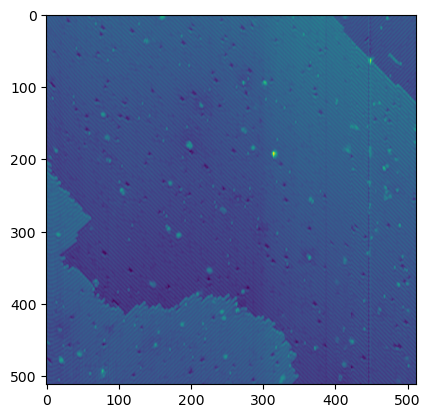

In [56]:
plt.imshow(AsH2[0,:,:])

In [ ]:
def train(model, dataloader_train, loss_, optimizer, num_epochs, model_name, dataloader_test):
    # define lists to store accuracy gain as we train
    train_acc_gain = []
    test_acc_gain = []

    best_accuracy = 0
    best_whole_img_acc = 0
    best_DS = 0
    best_whole_img_DS = 0

    model.train()
    model.to(device)

    # define 'best' model
    UNet_bright_best_loss = UNet()
    UNet_bright_best_acc = UNet()
    UNet_bright_best_DS = UNet()

    # Iterate over the training data
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        total = 0


        print('Epoch {} -------------------------------------------------------'.format(epoch))
        # train the model
        for i, (crops, labels) in enumerate(dataloader_train):
            #if i>n_samples: # we choose how many samples to use while training. Default is way larger than our dataset
            #    break
            # Get the crops and labels
            #crops, labels = crops.to(device), labels.to(device)
            crops, labels = crops.to(device), labels.to(device)

            # get prediction
            outputs = model(crops)

          # get loss
            loss = loss_(outputs, labels.data)
            running_train_loss += loss.item()
          # get accuracy
            predicted = torch.argmax(outputs.data, 1)
            running_train_accuracy += (predicted == labels.data ).sum().item()
          # find total
            total += labels.size(0)*labels.size(-1)*labels.size(-2) # it's a crop so there are labels.size(-1)*labels.size(-2) vectors per crop, and there are labels.size(0) crops

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Backward pass
            loss.backward()
            optimizer.step()


        print('epoch', epoch, 'train accuracy and loss over whole training set: {}%, {}'.format(100*running_train_accuracy/total, running_train_loss/len(dataloader_train)) )

        # get test accuracy and loss

        model.eval()
        accuracy, loss, diceScore = testAccuracy(model, dataloader_test, loss_)
        print('epoch {}. Test accuracy, dice score, and loss over whole test set: {}%, {}, {}'.format(epoch, accuracy, diceScore, loss))
       # whole_img_acc0, whole_img_DS0 = testWholeImgAcc(model, filled_AsEC1, maskAsEC1)
        whole_img_acc, whole_img_DS = testWholeImgAcc(model, filled_b, maskb)
      #  whole_img_acc = (whole_img_acc0+whole_img_acc1)/2
      #  whole_img_DS = (whole_img_DS0+whole_img_DS1)/2
        print('epoch {}. Test accuracy and dice score on whole image: {}%, {}'.format(epoch, whole_img_acc, whole_img_DS))

        # save the model if the test loss is the best
        if epoch == 0:
            save_model(model, './{}_best_loss.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_loss = loss
            print("new best loss model saved from epoch ", epoch)
        elif loss < best_loss:
            save_model(model, './{}_best_loss.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_loss = loss
            print("new best loss model saved from epoch ", epoch)

        # save the model if the test accuracy is the best
        if accuracy > best_accuracy:
            save_model(model, './{}_best_acc.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_accuracy = accuracy
            print("new best accuracy model saved from epoch ", epoch)

        if epoch==0:
            save_model(model, './{}_best_DS.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_DS = diceScore
            print("new best dice score model saved from epoch ", epoch)
        elif diceScore > best_DS:
            save_model(model, './{}_best_DS.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_DS = diceScore
            print("new best dice score model saved from epoch ", epoch)

        # save the model if whole image accuracy is the best
        if whole_img_acc > best_whole_img_acc:
            save_model(model, './{}_best_whole_img_acc.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_whole_img_acc = whole_img_acc
            print("new best whole image accuracy model saved from epoch ", epoch)

        # save the model if whole image DS is the best
        if epoch==0:
            save_model(model, './{}_best_whole_image_DS.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_whole_img_DS = whole_img_DS
            print("new best whole image dice score model saved from epoch ", epoch)
        elif whole_img_DS > best_whole_img_DS:
            save_model(model, './{}_best_whole_image_DS.pth'.format(model_name)) # "./As_11pix_single.pth")
            best_whole_img_DS = whole_img_DS
            print("new best whole image dice score model saved from epoch ", epoch)


        # show example every 5 epochs
        if epoch%3==0:
          print(epoch)
          test_and_plot_ex(UNet_bright_best_DS, UNet_bright_best_acc, model)

    return

Augment the training and test data by rotating and flipping it (and therefor have 8 times as much of it).

Build model and train

In [20]:
class DoubleConv(nn.Module):
    # a double convolution that does not change the resolution

    def __init__(self, n_channels1, n_channels2, n_channels3):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(n_channels1, n_channels2, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(n_channels2, eps=0.001, momentum = 0.99),
            nn.Conv2d(n_channels2, n_channels3, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(n_channels3, eps=0.001, momentum = 0.99)
        )

    def forward(self, x):
        return self.double_conv(x)



In [21]:
class downsample(nn.Module):
  # a double convolution followed by a maxpooling layer to downsample
  def __init__(self, n_channels1, n_channels2, n_channels3):
      super().__init__()
      self.doubleconvDown = DoubleConv(n_channels1, n_channels2, n_channels3)


  def forward(self, x):
      skip = self.doubleconvDown(x)
      y = nn.MaxPool2d(2)(skip)
      y = nn.Dropout(0.3)(y)
      return skip, y

In [22]:
class upsample(nn.Module):
  # a traspose convolution (to upsample) followed by a double convolution
  def __init__(self, n_channels1, n_channels2, n_channels3):
    super().__init__()
    self.convTranspose = nn.Sequential(nn.ConvTranspose2d(n_channels1, n_channels2, 2 , stride=2))#,
                                      # nn.BatchNorm2d(n_channels2, eps=0.001),
                                      # nn.ReLU(inplace=True))

    self.doubleConv = DoubleConv(n_channels1, n_channels2, n_channels3) #n_channels2 is first because it's concatenated with skip

  def forward(self, skip, x):
    # upsample
    x = self.convTranspose(x)
    # concatenate with the skip
    x = torch.concatenate([x, skip], axis=1)
    # dropout
    x = nn.Dropout(0.3)(x)
    # double convolution
    x = self.doubleConv(x)
    return x


In [23]:
class UNet(nn.Module):

    def __init__(self):
      super().__init__()
      # downsample 1
      self.downsample1 = downsample(1, 32, 32)
      # downsample 2
      self.downsample2 = downsample(32, 64, 64)
      # downsample 3
      self.downsample3 = downsample(64, 128, 128)

      # bottleneck
      self.bottleneck = DoubleConv(128,256,256)

      # upsample 1
      self.upsample1 = upsample(256, 128, 128)
      # upsample 2
      self.upsample2 = upsample(128, 64, 64)
      # upsample 3
      self.upsample3 = upsample(64, 32, 32)

      # final layer
      self.output = nn.Sequential(nn.Conv2d(32,2, kernel_size=1, padding="same"))#,
                                  #nn.Softmax2d())

    def forward(self, x):
      # downsample 1
      skip1, x1 = self.downsample1(x)
      # downsample 2
      skip2, x2 = self.downsample2(x1)
      # downsample 3
      skip3, x3 = self.downsample3(x2)

      # bottleneck
      bottleneck = self.bottleneck(x3)

      # upsample 1
      x4 = self.upsample1(skip3, bottleneck)
      # upsample 2
      x5 = self.upsample2(skip2, x4)
      # upsample 3
      x6 = self.upsample3(skip1, x5)

      outputs = self.output(x6)

      return outputs


In [24]:
# initialises parameters to glorot uniform
def init_weights(module):
  if isinstance(module, nn.Conv2d):
    torch.nn.init.xavier_uniform_(module.weight.data)
    if module.bias is not None:
      module.bias.data.zero_()
  elif isinstance(module, nn.ConvTranspose2d):
    torch.nn.init.xavier_uniform_(module.weight.data)
    if module.bias is not None:
      module.bias.data.zero_()


In [25]:
y_weights

NameError: name 'y_weights' is not defined

In [26]:
weights = torch.tensor([0.2,0.8])

In [27]:
# define unets#####
UNet_ = UNet().to(device)

In [31]:
UNet_.load_state_dict(torch.load('./models/UNet_Si.pth',map_location=torch.device('cpu')))
UNet_.to(device)
UNet_.eval()

C:\Users\nkolev\AppData\Local\Temp\ipykernel_1436\3167152619.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  UNet_.load_state_dict(torch.load('./models/UNet_Si.pth',map_

UNet(
  (downsample1): downsample(
    (doubleconvDown): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      )
    )
  )
  (downsample2): downsample(
    (doubleconvDown): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True,

In [30]:
# initialise the weights with glorot initialisation
UNet_.apply(init_weights)

UNet(
  (downsample1): downsample(
    (doubleconvDown): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      )
    )
  )
  (downsample2): downsample(
    (doubleconvDown): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True,

In [54]:
# Define the loss functions, and optimizer
criterion = nn.CrossEntropyLoss()#weight=weights.to(device))
#criterion = nn.BCELoss()
optimizer = optim.Adam(UNet_.parameters(), eps=1e-07, lr=0.01)
#optimizer = optim.SGD(UNet_bright.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 15, gamma=0.1) # lr=0.5*lr after every 5 epochs

number_epochs = 45

In [55]:
#modelName = "./As_11pix_single.pth"
#print( '{} has {} samples'.format(modelName, nSamples) )
train(UNet_, data_loaders_train, criterion, optimizer, num_epochs = number_epochs, model_name = 'bestUnet', dataloader_test = data_loaders_test)
print('-----------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train(UNet_bright, data_loaders_train, criterion, optimizer, num_epochs = number_epochs, model_name = 'bestUnet', dataloader_test = data_loaders_test)
print('-----------------------------------------------------------------------------------------')

In [ ]:
UNet_best_DS = UNet()
UNet_best_acc = UNet()

In [ ]:
# load best model
UNet_best_DS.load_state_dict(torch.load('./bestUnet_best_DS.pth'))
UNet_best_DS.eval().to(device)

UNet_best_acc.load_state_dict(torch.load('./bestUnet_best_acc.pth', map_location=torch.device('cpu')))
UNet_best_acc.to(device)

In [ ]:
UNet_bright.load_state_dict(torch.load('./UNet_Ge.pth',map_location=torch.device('cpu')))
UNet_bright.to(device)

In [ ]:
example1 = filled_AsEC1.copy()
# normalise it
example1 = (example1-np.min(example1))/(np.max(example1)-np.min(example1))


In [ ]:
# make crops torch tensors
example1 = torch.tensor(example1).float()
# send to GPU
example1 = example1.to(device)

In [ ]:
# make crops torch tensors
example1 = torch.tensor(example1).float()
# send to GPU
example1 = example1.to(device)
UNet_best_loss.eval()
UNet_best_acc.eval()
#get prediction
prediction1 = UNet_best_loss(example1.unsqueeze(0).unsqueeze(0))
prediction1 = prediction1.cpu().detach().numpy()

prediction2 = UNet_best_acc(example1.unsqueeze(0).unsqueeze(0))
prediction2 = prediction2.cpu().detach().numpy()

#prediction2 = UNet_bright(example1.unsqueeze(0).unsqueeze(0))
#prediction2 = prediction2.cpu().detach().numpy()


# plot best loss
fig, axs = plt.subplots(1, 3, figsize = (12,12))
# Plot data on each subplot
axs[1].imshow(prediction1[0,0,:,:]>prediction1[0,1,:,:])
axs[0].imshow(example1[:,:].cpu().detach().numpy())
axs[2].imshow(maskk)

# plot best acc
fig, axs = plt.subplots(1, 2, figsize = (12,12))
# Plot data on each subplot
axs[0].imshow(prediction2[0,0,:,:]>prediction2[0,1,:,:])#>0.5)
axs[1].imshow(example1[:,:].cpu().detach().numpy())


In [ ]:
plt.imshow(maskk)

In [ ]:
%pip install patchify

In [ ]:
import patchify as pat

In [ ]:
AsH2.shape

In [44]:
# normalisation for unets (min/max)
def norm2(array, error=False):
    min_filled = np.expand_dims(np.amin(array[:,0,:,:], axis=(1,2)), axis=(1,2))
    max_filled = np.expand_dims(np.amax(array[:,0,:,:], axis=(1,2)), axis=(1,2))

    array[:,0,:,:] = (array[:,0,:,:]-min_filled)/(max_filled-min_filled)

    return array

In [ ]:
res=512

win_size=32
dim = ((res-win_size)//(win_size//2))+1
#  exampleSi = filled_k.copy()
#  exampleGe = filled_9_1_2.copy()
example1 = np.reshape( pat.patchify(filled_b.copy(), (win_size, win_size), step = win_size//2), (dim**2,1,win_size,win_size))
# normalise it
example1 = norm2(example1)
example1 = torch.tensor(example1).float()
# send to GPU
example1 = example1.to(device)
unet_prediction1 = UNet_best_acc(example1).cpu().detach().numpy()
prediction1 = np.zeros((2,res,res))
unet_prediction1 = np.reshape(unet_prediction1, ( dim, dim, 2, 1, win_size, win_size))
#print(unet_prediction1.shape, prediction1.shape)
# To get rid of edge effects of the U-Net, we take smaller steps so each crop overlaps and then take an average over the crops
# takes a bit longer to compute but is more accurate
for i in range(dim):
    for j in range(dim):
        prediction1[:,i*(win_size//2):(i*(win_size//2))+win_size, j*(win_size//2):(j*(win_size//2))+win_size] = prediction1[:,i*(win_size//2):(i*(win_size//2))+win_size, j*(win_size//2):(j*(win_size//2))+win_size] + unet_prediction1[i,j,:,0,:,:]

fig, axs = plt.subplots(1, 2, figsize = (12,12))
# Plot data on each subplot
axs[0].imshow(prediction1[0,:,:]>prediction1[1,:,:])#>0.5)
axs[1].imshow(filled_b, cmap='afmhot')
plt.show()


In [ ]:
res=512

win_size=32
dim = ((res-win_size)//(win_size//2))+1
#  exampleSi = filled_k.copy()
#  exampleGe = filled_9_1_2.copy()
example1 = np.reshape( pat.patchify(filled_n.copy(), (win_size, win_size), step = win_size//2), (dim**2,1,win_size,win_size))
# normalise it
example1 = norm2(example1)
example1 = torch.tensor(example1).float()
# send to GPU
example1 = example1.to(device)
unet_prediction1 = UNet_best_acc(example1).cpu().detach().numpy()
prediction1 = np.zeros((2,res,res))
unet_prediction1 = np.reshape(unet_prediction1, ( dim, dim, 2, 1, win_size, win_size))
#print(unet_prediction1.shape, prediction1.shape)
# To get rid of edge effects of the U-Net, we take smaller steps so each crop overlaps and then take an average over the crops
# takes a bit longer to compute but is more accurate
for i in range(dim):
    for j in range(dim):
        prediction1[:,i*(win_size//2):(i*(win_size//2))+win_size, j*(win_size//2):(j*(win_size//2))+win_size] = prediction1[:,i*(win_size//2):(i*(win_size//2))+win_size, j*(win_size//2):(j*(win_size//2))+win_size] + unet_prediction1[i,j,:,0,:,:]

fig, axs = plt.subplots(1, 2, figsize = (12,12))
# Plot data on each subplot
axs[0].imshow(prediction1[0,:,:]>prediction1[1,:,:])#>0.5)
axs[1].imshow(filled_n, cmap='afmhot')
plt.show()

In [ ]:
def dice_score_np(ground_truth, predicted):
    """
    Calculate the Dice score for binary segmentation.

    Parameters:
    - ground_truth: Binary array representing the ground truth segmentation.
    - predicted: Binary array representing the predicted segmentation.

    Returns:
    - Dice score (float).
    """

    # Ensure the input arrays have the same shape
    if ground_truth.shape != predicted.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Calculate the intersection, ground truth, and predicted counts
    intersection = np.sum(np.logical_and(ground_truth, predicted))
    ground_truth_count = np.sum(ground_truth)
    predicted_count = np.sum(predicted)

    # Calculate the Dice score
    dice = (2.0 * intersection) / (ground_truth_count + predicted_count)

    return dice

In [32]:
dice_score_np(maskb, prediction1[0,:,:]<prediction1[1,:,:])

NameError: name 'dice_score_np' is not defined

In [ ]:
dice_score_np(maskn, prediction1[0,:,:]<prediction1[1,:,:])

In [ ]:
(0.61952+0.446582)/2

In [ ]:
accuracy = ((prediction1[0,:,:]<prediction1[1,:,:])== maskb ).sum().item()/(512**2)

In [ ]:
accuracy

In [ ]:
plt.imshow(AsH2[:,:,0], cmap='Greys')

In [ ]:
example2 = np.reshape(pat.patchify(AsEC[:,:,:2], (32, 32, 2), step = 32), (dim**2,32,32,2))
# normalise it
example2 = normalise(example2)
prediction2 = model1(example2)
repatched_pred2 = pat.unpatchify( np.reshape(prediction2, (dim, dim, 1, 32, 32, 2)), (512, 512, 2))
plt.imshow(AsEC[:,:,0]+0.5*(repatched_pred2[:,:,1]>repatched_pred2[:,:,0]), cmap='Greys')

In [ ]:
plt.imshow(repatched_pred2[:,:,1], cmap='Greys')

In [ ]:
from torchsummary import summary

In [ ]:
img1= torch.tensor(filled_gr).float()
img2= torch.tensor(filled_k).float()


mask1= torch.tensor(maskgr.copy()).float().unsqueeze(0)
mask1 = transforms.functional.resize(mask1, (520,520))

In [ ]:
img1 = torch.stack((img1,img1,img1))
img2 = torch.stack((img2,img2,img2))

In [ ]:
UNet_med = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

In [ ]:
# Extract pretrained layers
pretrained_layers = []
for name, param in UNet.named_parameters():
    pretrained_layers.append((name, param))


In [ ]:
summary(UNet_med, (3,256,256))

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor


In [ ]:
for name in UNet_med.named_children():
  print(name)

In [ ]:
return_nodes = {"decoder1.dec1relu1": 'output2', "upconv1": 'output1', }

model = create_feature_extractor(UNet_med, return_nodes=return_nodes)
intermediate_outputs = model(x)['output2']

In [ ]:
class unetprototype(nn.Module):
    def __init__(self, model, output):
        super().__init__()

        self.features = model
        self.output = output

    def forward(self, support, query):
        # embed support and query
        support['embeddings'] = self.features(support['image'])[self.output]
        support['flat embeddings'] = torch.flatten(support['embeddings'], start_dim=2,end_dim=3)

        query['embeddings'] = self.features(query['image'])[self.output]
        query['flat embeddings'] = torch.flatten(query['embeddings'], start_dim=2,end_dim=3)
        # now we need to compute the prototype for each class
        support_embeds = []
        for i in range(2):
            #support['target'].shape = (1,res,res)
            embeds = support["flat embeddings"].squeeze(0)[:,torch.flatten(support["target"], start_dim=1,end_dim=2).squeeze(0) == i]
            support_embeds.append(embeds)
        # support_embeds is a list of torch tensors of shape
        # (n_support, dimensions of embedding vector space)

        # we compute the mean of these support vectors to get prototypes
        prototypes = []
        for tensor in support_embeds:
          prototype = tensor.mean(dim = 1 )
          prototypes.append(prototype)

        support["prototypes"] = torch.stack(prototypes)

        # support["prototypes"] is a tensor of shape
        # (n_way, dimensions of embedding vector space)

        # compute the distances between the query embeddings and the prototypes
        # query['embeddings'] is a tensor of shape (n_samples, dimensions of embedding vector space)
        distances = torch.cdist(torch.transpose(query["flat embeddings"].squeeze(0), 0,1), support['prototypes'].unsqueeze(0), p=2).squeeze(0)
        # distances is a tensor of dimensions (n_samples, n_ways)
        distances = distances ** 2

        # the negative of the distances give the final output logits
        logits = - distances

        # restore shape
        output = torch.argmax(logits, dim=1).reshape((256,256))

        return output

In [ ]:
protoUnet = unetprototype(model, 'output2')

In [ ]:
def z_score_norm(tensor):
  m = torch.mean(tensor)
  std = torch.std(tensor)
  return (tensor-m)/std

In [ ]:
# Step 3: Apply inference preprocessing transforms
batch1 = z_score_norm(img1[:,:256,:256]).unsqueeze(0)#.unsqueeze(0)
batch2 = z_score_norm(img2[:,:256,:256]).unsqueeze(0)#.unsqueeze(0)

In [ ]:
batch1.shape

In [ ]:
support = {'image': batch1, 'target': mask1[:,:256,:256]}
query = {'image': batch2}

In [ ]:
l = protoUnet(support, query)

In [ ]:
plt.imshow(l)

In [ ]:
plt.imshow(batch2[0,0,:,:])